# Import libraries

In [273]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import re
from scipy.stats import truncnorm

# Generate Graph

In [13]:
def generate_graph(graph_type, n, d=None):
    if graph_type=="complete":
        return nx.complete_graph(n)
    elif graph_type=="d-regular" and d is not None:
        return nx.random_regular_graph(d, n)
    else:
        raise NotImplementedError("Use only 'complete' or 'd-regular'(with d) ")

# Create approved voters set ($J(i)$)
- A is $\alpha$

In [20]:
def get_approved_voters(voting_probs, A):
    approved_voters = {}
    for i in voting_probs:
        approved_voters[i] = {j for j in voting_probs if voting_probs[i]+A <= voting_probs[j]}
    return approved_voters

# Vote delegation 
- threshold is $j$

In [24]:
def vote_delegation(approved_voters, threshold):
    delegations = {}
    for voter, J in approved_voters.items():
        if len(J) > threshold:
            delegations[voter] = random.choice(list(J))
    return delegations

# Simulation of delegations

In [395]:
def simulate(G, delegations, voting_probs, max_depth = 3):
    votes = {}
    vote_result = {}
    node_depth = {}
    
    def resolve_vote(voter):
        depth=0
        visited = set()
        while voter in delegations and delegations[voter] in G:
            if delegations[voter] in visited:
                return None #prevent cycle delegation
            if depth >= max_depth:
                return voter  # stop delegation here
            visited.add(voter)
            voter = delegations[voter] #do semi-recursive loop
            depth += 1
            
        return voter
    
    #resolve vote path and simulate the trusted voter
    for voter in G.nodes:
        votes[voter] = resolve_vote(voter)
        if votes[voter] == voter:
            vote_result[voter] = np.random.binomial(1, voting_probs.get(voter))
            
    #Aggregate the voting result
    for voter in G.nodes:
        if votes[voter] != voter:
            vote_result[voter] = vote_result[votes[voter]]
        
    return vote_result

# Parameters setting

- **d** is Degree of random d-regular
- **n** is the number of nodes in the graph
- **threshold** is $j$ where the delegation happens if $|J(i)| > j$

In [382]:
graph_type = ['complete', 'd-regular']
g_type = 0
d = 3
n = 1000

# Main code

# Threshold effect on the delegation of Fully connected graph (with std=0.1)

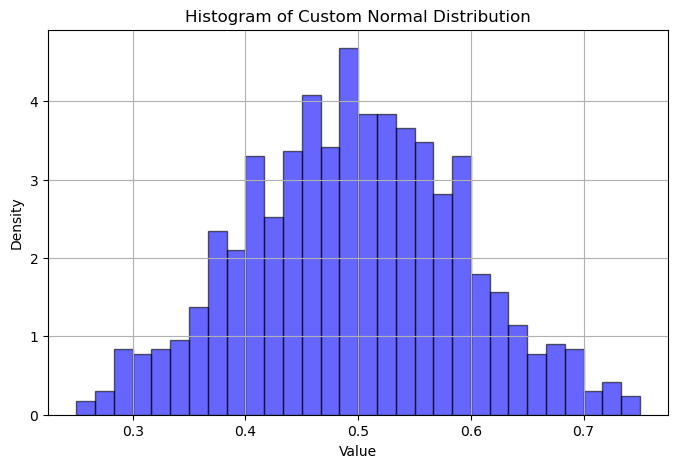

In [416]:
mean = 0.5
std = 0.1
min_val = 0.25
max_val = 0.75

# Make probability distribution
a, b = (min_val - mean) / std, (max_val - mean) / std
data = truncnorm.rvs(a, b, loc=mean, scale=std, size=n)
clipped_data = np.clip(data, min_val, max_val)

# Normalize to force exact min/max while keeping shape
scaled_data = (clipped_data - clipped_data.min()) / (clipped_data.max() - clipped_data.min())
data = scaled_data * (max_val - min_val) + min_val

#Generate graph
G = generate_graph(graph_type[g_type], n, d)

#Set voting probability for each node i
voting_probs = {i: data[i] for i in range(n)}

plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Custom Normal Distribution')
plt.grid(True)
plt.show()

Threshold loop (A=0.2):  72%|█████████████▋     | 36/50 [06:06<02:25, 10.40s/it]


A_set loop: 100%|████████████████████████████████| 5/5 [44:47<00:00, 537.52s/it]


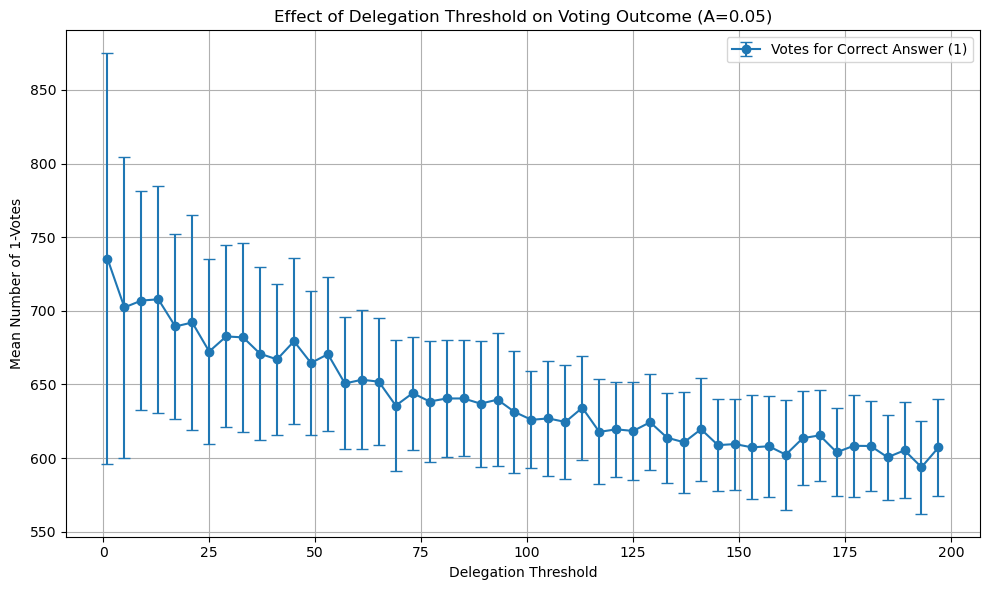

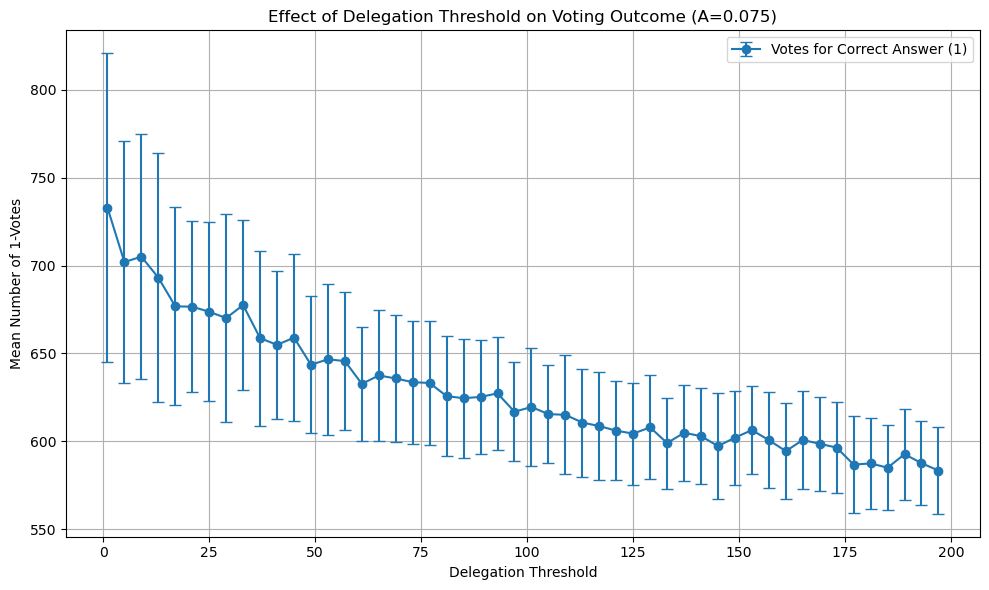

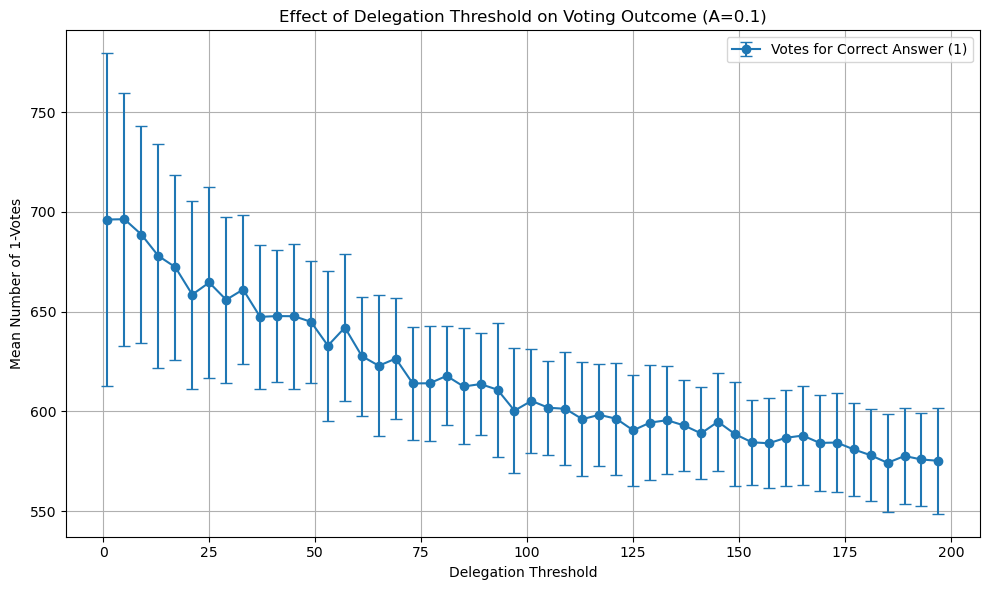

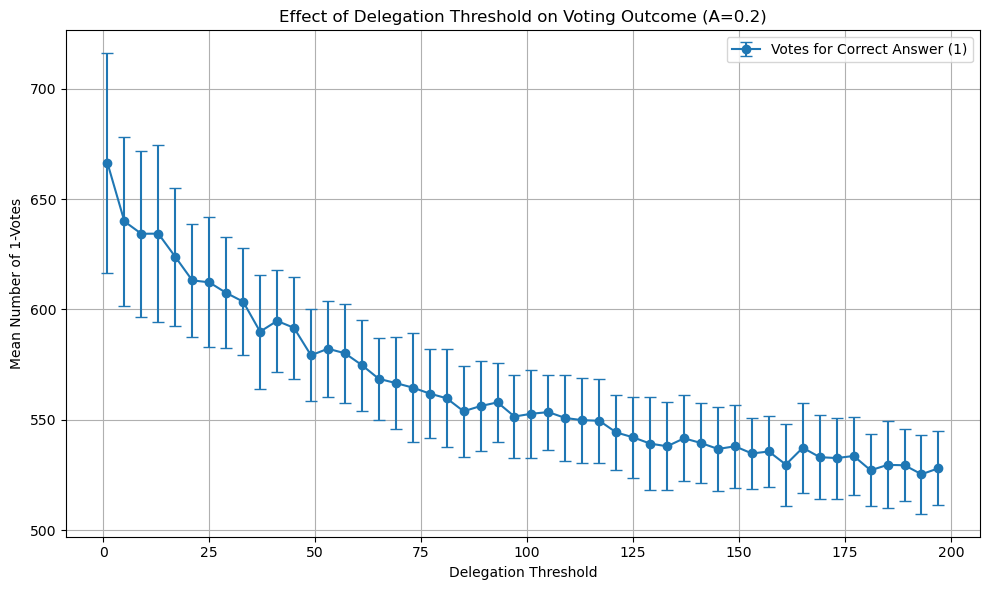

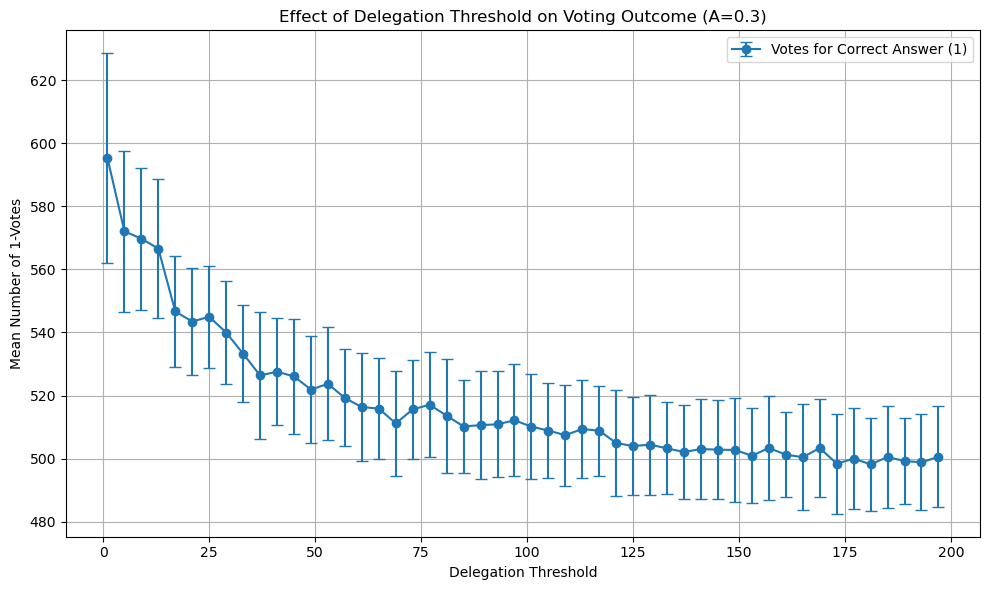

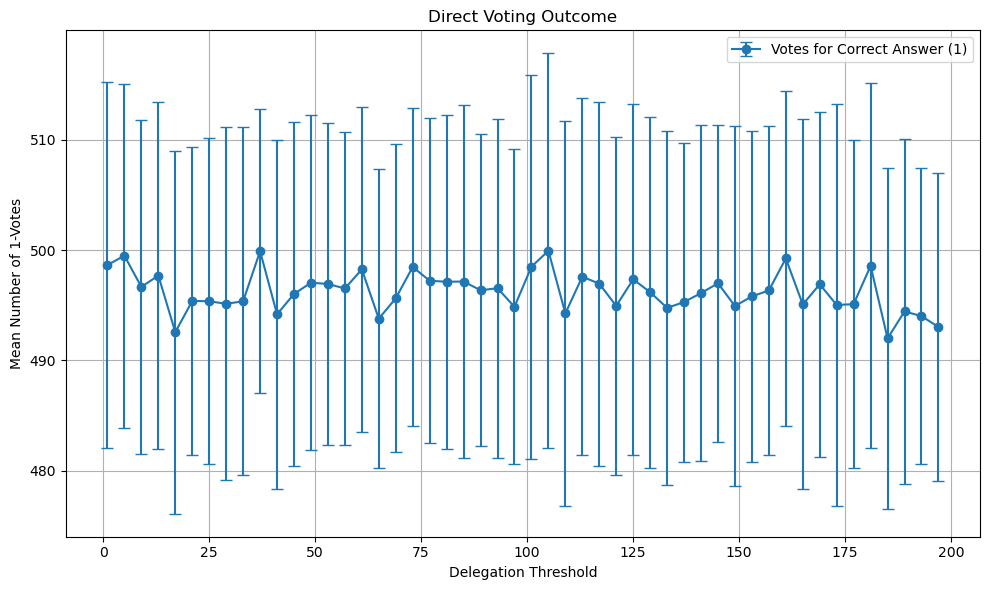

In [417]:
from tqdm import tqdm

A_set = [0.05, 0.075, 0.1, 0.2, 0.3]
iterate = 100  # Number of repetitions per threshold

for A in tqdm(A_set, desc='A_set loop'):
    mean_ones = []
    std_ones = []
    mean_direct_ones = []
    std_direct_ones = []

    for threshold in tqdm(range(1, 200, 4), desc=f'Threshold loop (A={A})', leave=False):
        threshold_ones = []
        direct_ones = []

        for _ in range(iterate):
            approved_voters = get_approved_voters(voting_probs, A)
            delegations = vote_delegation(approved_voters, threshold)
            votes = simulate(G, delegations, voting_probs)

            # Delegated votes
            final_votes = np.array(list(votes.values()))
            count_ones = np.sum(final_votes == 1)

            # Direct votes (no delegation)
            direct_votes = np.random.binomial(1, np.array(list(voting_probs.values())))
            count_do = np.sum(direct_votes == 1)

            threshold_ones.append(count_ones)
            direct_ones.append(count_do)

        # Aggregate stats for this threshold
        mean_ones.append(np.mean(threshold_ones))
        std_ones.append(np.std(threshold_ones))
        mean_direct_ones.append(np.mean(direct_ones))
        std_direct_ones.append(np.std(direct_ones))
        
    thresholds = list(range(1, 200, 4))
    title = f'Effect of Delegation Threshold on Voting Outcome (A={A})'
    filename = re.sub(r'[^\w\s-]', '', title).replace(' ', '_') + '.png'
    plt.figure(figsize=(10, 6))
    plt.errorbar(thresholds, mean_ones, yerr=std_ones, fmt='-o', capsize=4, color='tab:blue', label='Votes for Correct Answer (1)')
    plt.title(title)
    plt.xlabel('Delegation Threshold')
    plt.ylabel('Mean Number of 1-Votes')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.savefig(f'exp3/iter/{iterate}/{filename}')
#     plt.show()
 
plt.figure(figsize=(10, 6))
plt.errorbar(thresholds, mean_direct_ones, yerr=std_direct_ones, fmt='-o', capsize=4, color='tab:blue', label='Votes for Correct Answer (1)')

title = f'Direct Voting Outcome'
filename = re.sub(r'[^\w\s-]', '', title).replace(' ', '_') + '.png'
plt.title(title)
plt.xlabel('Delegation Threshold')
plt.ylabel('Mean Number of 1-Votes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'exp3/iter/{iterate}/{filename}')


# Threshold effect on the delegation of Fully connected graph (with std=0.2)

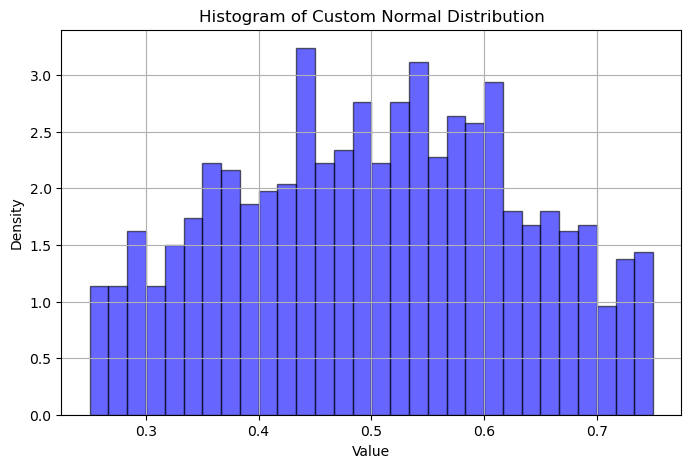

In [418]:
mean = 0.5
std = 0.2
min_val = 0.25
max_val = 0.75

# Make probability distribution
a, b = (min_val - mean) / std, (max_val - mean) / std
data = truncnorm.rvs(a, b, loc=mean, scale=std, size=n)
clipped_data = np.clip(data, min_val, max_val)

# Normalize to force exact min/max while keeping shape
scaled_data = (clipped_data - clipped_data.min()) / (clipped_data.max() - clipped_data.min())
data = scaled_data * (max_val - min_val) + min_val

#Generate graph
G = generate_graph(graph_type[g_type], n, d)

#Set voting probability for each node i
voting_probs = {i: data[i] for i in range(n)}

plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Custom Normal Distribution')
plt.grid(True)
plt.show()


Threshold loop (A=0.2):  72%|█████████████▋     | 36/50 [06:19<02:28, 10.60s/it]


A_set loop: 100%|████████████████████████████████| 5/5 [45:55<00:00, 551.05s/it]


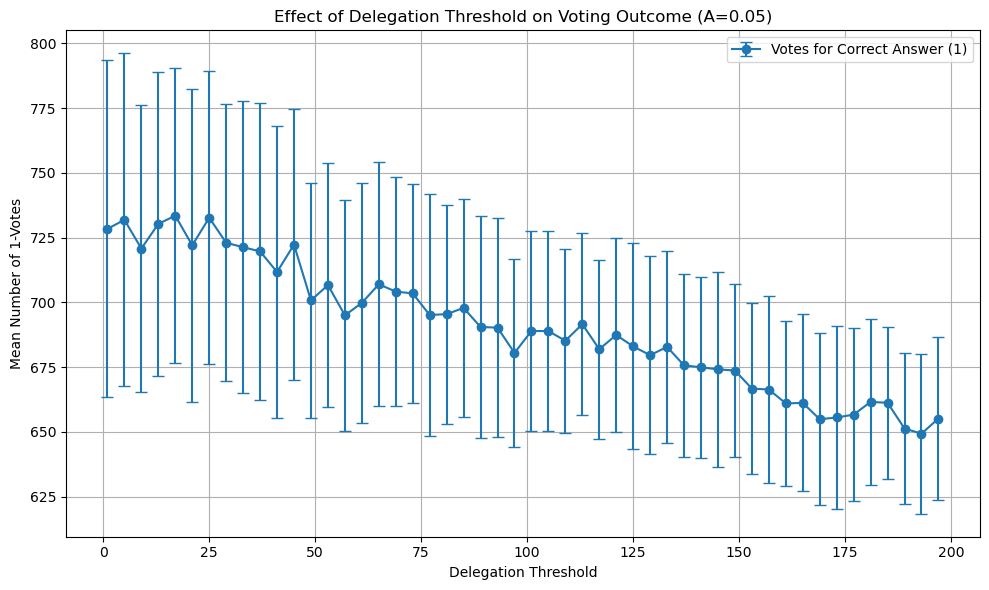

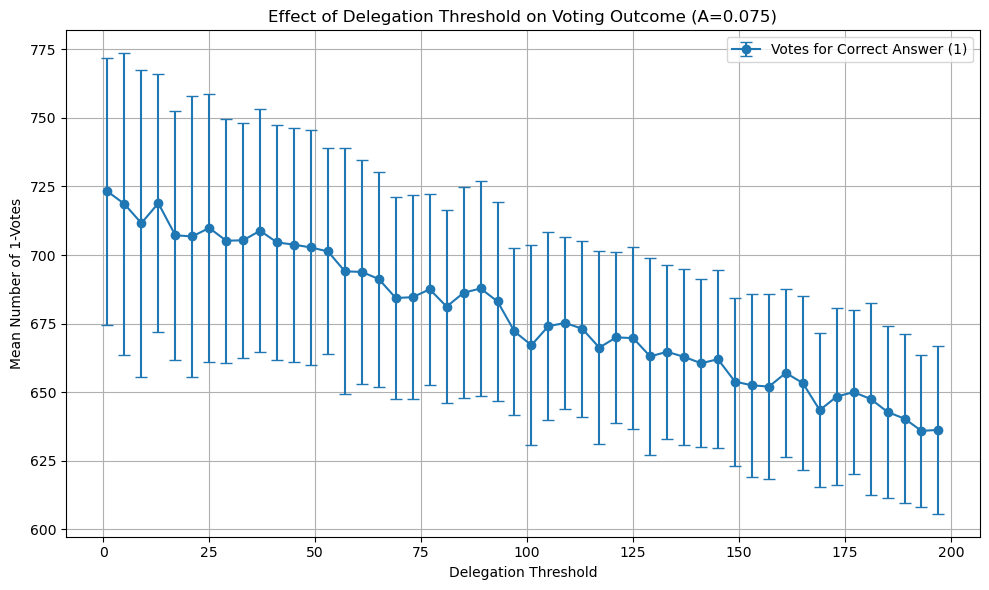

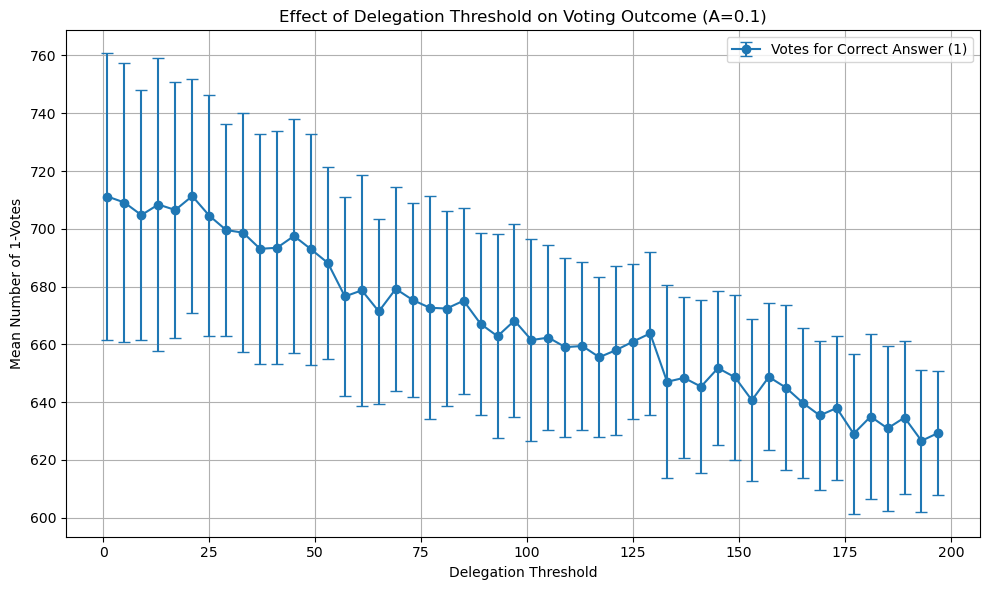

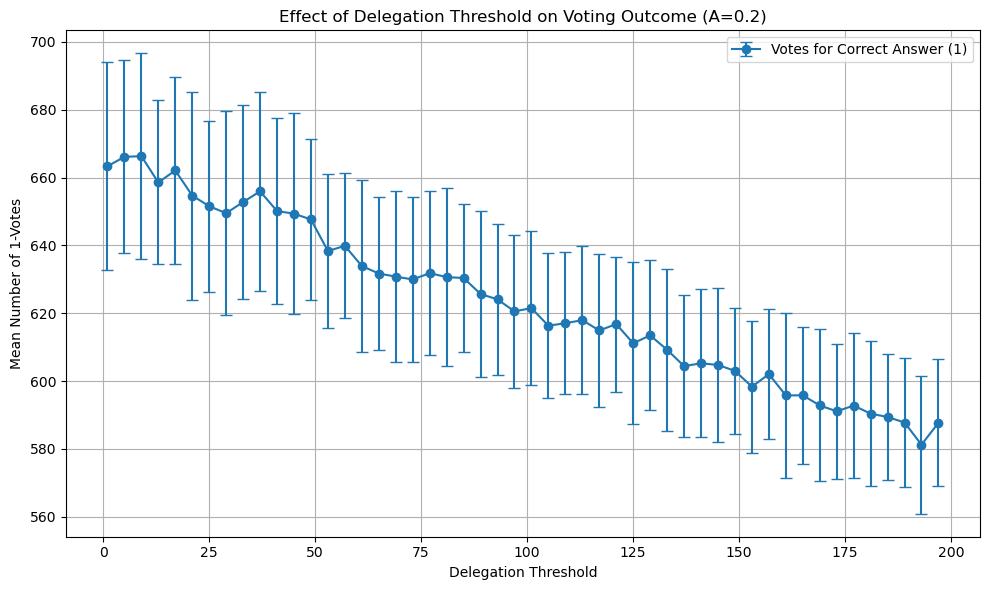

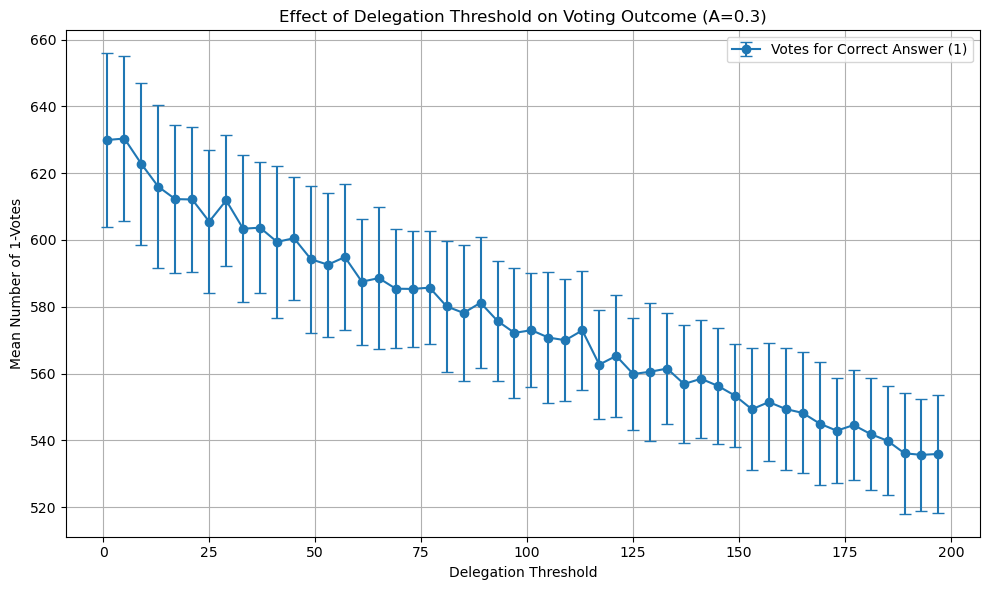

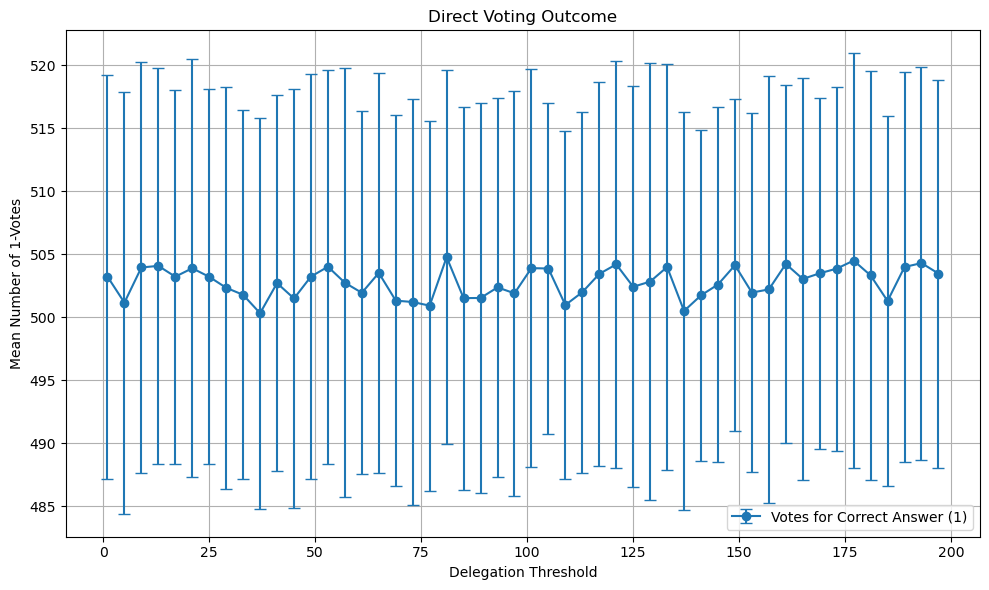

In [419]:
from tqdm import tqdm

A_set = [0.05, 0.075, 0.1, 0.2, 0.3]
iterate = 100  # Number of repetitions per threshold

for A in tqdm(A_set, desc='A_set loop'):
    mean_ones = []
    std_ones = []
    mean_direct_ones = []
    std_direct_ones = []

    for threshold in tqdm(range(1, 200, 4), desc=f'Threshold loop (A={A})', leave=False):
        threshold_ones = []
        direct_ones = []

        for _ in range(iterate):
            approved_voters = get_approved_voters(voting_probs, A)
            delegations = vote_delegation(approved_voters, threshold)
            votes = simulate(G, delegations, voting_probs)

            # Delegated votes
            final_votes = np.array(list(votes.values()))
            count_ones = np.sum(final_votes == 1)

            # Direct votes (no delegation)
            direct_votes = np.random.binomial(1, np.array(list(voting_probs.values())))
            count_do = np.sum(direct_votes == 1)

            threshold_ones.append(count_ones)
            direct_ones.append(count_do)

        # Aggregate stats for this threshold
        mean_ones.append(np.mean(threshold_ones))
        std_ones.append(np.std(threshold_ones))
        mean_direct_ones.append(np.mean(direct_ones))
        std_direct_ones.append(np.std(direct_ones))
        
    thresholds = list(range(1, 200, 4))
    title = f'Effect of Delegation Threshold on Voting Outcome (A={A})'
    filename = re.sub(r'[^\w\s-]', '', title).replace(' ', '_') + '.png'
    plt.figure(figsize=(10, 6))
    plt.errorbar(thresholds, mean_ones, yerr=std_ones, fmt='-o', capsize=4, color='tab:blue', label='Votes for Correct Answer (1)')
    plt.title(title)
    plt.xlabel('Delegation Threshold')
    plt.ylabel('Mean Number of 1-Votes')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.savefig(f'exp3/std/{filename}')
#     plt.show()
 
plt.figure(figsize=(10, 6))
plt.errorbar(thresholds, mean_direct_ones, yerr=std_direct_ones, fmt='-o', capsize=4, color='tab:blue', label='Votes for Correct Answer (1)')

title = f'Direct Voting Outcome'
filename = re.sub(r'[^\w\s-]', '', title).replace(' ', '_') + '.png'
plt.title(title)
plt.xlabel('Delegation Threshold')
plt.ylabel('Mean Number of 1-Votes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'exp3/std/{filename}')
